<a href="https://colab.research.google.com/github/Dibya069/AGI-ChatBot/blob/main/Sample_AGI_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langchain_core langchain_groq groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36


In [2]:
!pip install wikipedia langgraph

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 13.4 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=a3294f122d2db2c9682edb257c3e0d983bf22405aef568724e277b5aa86fdfac
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [3]:
import os

from langchain.chains import LLMChain
from langchain_core.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.messages import SystemMessage
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain_groq import ChatGroq

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver
# 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

In [5]:
import os
import getpass


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("TAVILY_API_KEY") # T

Please provide your TAVILY_API_KEY··········


In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Get Groq API key
groq_api_key = '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'
model = 'llama3-8b-8192'

groq_chat = ChatGroq(
        groq_api_key=groq_api_key,
        model_name=model
)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)
tavily_tool = TavilySearchResults(max_results=5)

tools = [wikipedia_tool]
tool_node = ToolNode(tools=[wikipedia_tool])

memory = MemorySaver()

In [7]:
graph_builder = StateGraph(State)
llm_with_tools = groq_chat.bind_tools(tools)

In [8]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")
graph_memory = graph_builder.compile(checkpointer=memory)

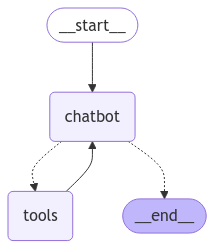

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph_memory.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
config = {"configurable": {"thread_id": "1"}}

while 1:
  user_input = input("User : ")
  if user_input.lower() in ["quit", "q"]:
    print("Good Bye")
    break

  events = graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
  )

  for event in events:
    print(event["messages"][-1].pretty_print())

User : who is SRK
================================ Human Message =================================

who is SRK
None
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_nj7n)
 Call ID: call_nj7n
  Args:
    query: Shah Rukh Khan
None
================================= Tool Message =================================
Name: wikipedia

Page: Shah Rukh Khan
Summary: Shahrukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100
None
================================== Ai Message ==================================

SRK is a nickname for Shah Rukh Khan, a renowned Indian actor, film producer, and television personality. He is one of the most successful and beloved film stars in Indian cinema, known for his charismatic performances and

In [11]:
snapshot = graph_memory.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================

Shah Rukh Khan has produced several films through his production company, Red Chillies Entertainment. Some of the notable films produced by him include:

* Phir Bhi Dil Hai Hindustani (2000)
* Chalte Chalte (2003)
* Main Hoon Na (2004)
* Paheli (2005)
* Om Shanti Om (2007)
* Billu (2009)
* My Name Is Khan (2010)
* Always Kabhi Kabhi (2011)
* Chennai Express (2013)
* Happy New Year (2014)
* Dilwale (2015)

Note: This is not an exhaustive list, as SRK has produced many more films through his production company.


In [12]:
tom = snapshot.values["messages"]

In [13]:
res = existing_message.content

In [14]:
print(tom)

[HumanMessage(content='who is SRK', additional_kwargs={}, response_metadata={}, id='60f2a89c-400e-42d0-8f9e-7ae29984b05c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nj7n', 'function': {'arguments': '{"query":"Shah Rukh Khan"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 945, 'total_tokens': 1029, 'completion_time': 0.07, 'prompt_time': 0.053465425, 'queue_time': 0.0018267060000000043, 'total_time': 0.123465425}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-96647bcc-28e5-43af-816f-f52e86b723a9-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Shah Rukh Khan'}, 'id': 'call_nj7n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 945, 'output_tokens': 84, 'total_tokens': 1029}), ToolMessage(content='Page: Shah Rukh Khan\nSummary: Shahrukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 